In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from scipy.sparse.csgraph import laplacian

pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


In [3]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=1, extents=(1, 40), duration_of_trial=0.001, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 334.26it/s]


Using pyvistaqt 3d backend.

Using control points [0.00000000e+00 0.00000000e+00 3.15083634e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# Algo

## Helpers

ye
(5, 64, 64, 1) (5, 1284)
No projector specified for this dataset. Please consider the method self.add_proj.


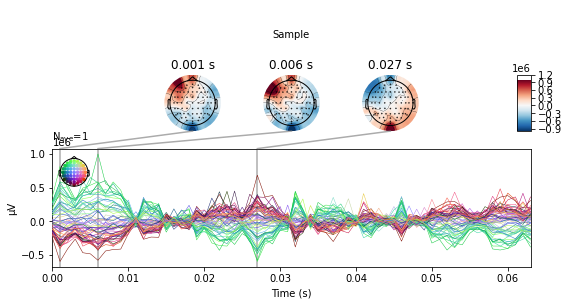

Using control points [2.03021826e-05 1.34501960e-04 2.05948822e-02]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [2.03021826e-05 1.34501960e-04 2.05948822e-02]


In [10]:
def rms(x):
        return np.sqrt(np.mean(x**2))
    
def add_white_noise(X_clean, snr):
    ''' '''
    X_noise = np.random.randn(*X_clean.shape)

    rms_clean = rms(X_clean)
    scaler = rms_clean / snr

    X_full = X_clean + X_noise*scaler
    X_full -= X_full.mean(axis=0)
    return X_full
    
def generator(fwd, batch_size=1284, batch_repetitions=30, n_sources=2, n_orders=4, amplitude_range=(0.001,1), n_timepoints=20, snr_range=(1, 100), verbose=0):
    adjacency = mne.spatial_src_adjacency(fwd["src"], verbose=verbose).toarray()
    gradient = abs(laplacian(adjacency))
    leadfield = fwd["sol"]["data"]
    leadfield -= leadfield.mean()

    # leadfield_norm = deepcopy(leadfield)
    # leadfield_norm /= np.linalg.norm(leadfield_norm, axis=0)

    n_chans, n_dipoles = leadfield.shape


    sources = np.identity(n_dipoles)
    for _ in range(n_orders-1):
        new_sources = sources[-n_dipoles:, -n_dipoles:] @ gradient
        new_sources /= new_sources.max(axis=0)
        sources = np.concatenate( [sources, new_sources], axis=0 )

    time_courses = np.stack([np.random.randn(n_timepoints) for _ in range(1000)], axis=0)

    

    n_candidates = sources.shape[0]

    while True:
        print("ye")
        # select sources
        n_sources_batch = np.random.randint(1, n_sources+1, batch_size)
        selection = [np.random.randint(0, n_candidates, n) for n in n_sources_batch]

        # Give them a time course
        amplitudes = [time_courses[np.random.choice(np.arange(time_courses.shape[0]), n)].T * np.random.uniform(*amplitude_range, n) for n in n_sources_batch]
        y = np.stack([(amplitudes[i] @ sources[selection[i]]) / len(amplitudes[i]) for i in range(batch_size)], axis=0)
        
        # Project simulated sources through leadfield
        x = np.stack([leadfield @ yy.T for yy in y], axis=0)

        # Add white noise to clean EEG
        snr_levels = np.random.uniform(low=snr_range[0], high=snr_range[1], size=batch_size)
        x = np.stack([add_white_noise(xx, snr_level) for (xx, snr_level) in zip(x, snr_levels)], axis=0)

        # Apply common average reference
        x = np.stack([xx - xx.mean(axis=0) for xx in x], axis=0)
        # Calculate Covariance
        cov = np.stack([xx@xx.T for xx in x], axis=0)

        # Normalize Covariance to abs. max. of 1
        cov = np.stack([C / np.max(abs(C)) for C in cov], axis=0)
        cov = np.expand_dims(cov, axis=-1)
        
        # Calculate mean source activity
        y = abs(y).mean(axis=1)
        
        # Return same batch multiple times:
        for _ in range(batch_repetitions):
            yield (cov, y)


gen = generator(fwd, batch_size=5, n_sources=4, n_timepoints=20, snr_range=(0.5, 1))
x_test, y_test = gen.__next__()
print(x_test.shape, y_test.shape)
i = 0
evoked_ = mne.EvokedArray(x_test[i, :, :, 0].T, evoked.info)
evoked_.plot_joint(title="Sample")

stc_ = stc.copy()

stc_.data[:, 0] = y_test[i]
stc_.plot(**pp)

# Training

## CNN

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape
from tensorflow.keras import backend as K
tf.keras.backend.set_image_data_format('channels_last')

n_channels = evoked.data.shape[0]
n_dipoles = x.shape[0]

# Architecture Params
n_filters = 64
activation_function = "tanh"
batch_size = int(n_dipoles)

# Simulation Params
n_sources = 10
n_orders = 3
n_timepoints = 20
batch_repetitions = 10
gen_args = dict(batch_size=batch_size, batch_repetitions=batch_repetitions, 
                n_sources=n_sources, n_orders=n_orders, n_timepoints=n_timepoints)


# Training Params
epochs = 300
steps_per_epoch = batch_repetitions

n_hl = 1

inputs = tf.keras.Input(shape=(n_channels, n_channels, 1), name='Input')

cnn1 = Conv2D(n_filters, (1, n_channels),
            activation=activation_function, padding="valid",
            name='CNN1')(inputs)

# for n in range(n_hl):
#     reshape = Reshape((n_channels, n_filters, 1))(cnn1)
#     cnn1 = Conv2D(n_filters, (int(n_channels/2), int(n_channels/2)),
#             activation=activation_function, padding="valid",
#             name='CNN' + str(n+2))(reshape)

flat = Flatten()(cnn1)

# flat = Dense(300, 
#             activation=activation_function, 
#             name='HLfin')(flat)

out = Dense(n_dipoles, 
            activation="relu", 
            name='Output')(flat)

model = tf.keras.Model(inputs=inputs, outputs=out, name='CovCNN')
model.compile(loss="cosine_similarity", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.summary()

gen = generator(fwd, **gen_args)
gen_args["batch_size"] = 256
gen_val = generator(fwd, **gen_args)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),]
model.fit(x=gen, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=gen_val.__next__(), callbacks=callbacks)


Model: "CovCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 1)]       0         
                                                                 
 CNN1 (Conv2D)               (None, 64, 1, 64)         4160      
                                                                 
 flatten_24 (Flatten)        (None, 4096)              0         
                                                                 
 Output (Dense)              (None, 1284)              5260548   
                                                                 
Total params: 5,264,708
Trainable params: 5,264,708
Non-trainable params: 0
_________________________________________________________________
ye
ye
Epoch 1/300
10/10 [==============================] - 1s 59ms/step - loss: -0.2092 - val_loss: -0.1993
Epoch 2/300
10/10 [==============================] - 2s 32ms/step - loss: 

# Eval

In [57]:
gen_args = dict(batch_size=batch_size, batch_repetitions=batch_repetitions, 
                n_sources=n_sources, n_orders=n_orders, n_timepoints=n_timepoints)
gen_args["batch_size"] = 1


gen_tst = generator(fwd, **gen_args)

x_test, y_test = gen_tst.__next__()

y_hat = model.predict(x_test, verbose=0)

stc_ = stc.copy()
stc_.data = y_test.T
stc_.plot(**pp, brain_kwargs=dict(title="Ground Truths"), colormap="Reds")

stc_ = stc.copy()
stc_.data = y_hat.T
stc_.plot(**pp, brain_kwargs=dict(title="Preds"), colormap="Reds")



ye
Using control points [0.         0.         0.02859662]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Using control points [0.         0.         0.02650734]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.         0.         0.02859662]
Using control points [0.         0.         0.02650734]
Using control points [0.         0.         0.02650734]


In [55]:
C = np.random.randn(64, 64)
C = C[np.newaxis, :, :, np.newaxis]
out = model.predict(C)

1/1 [==============================] - 0s 20ms/step


In [61]:
gammas = deepcopy(y_test)
gammas /= gammas.max()
(gammas<0.5).sum()

1282